In [67]:
import os
import ast
import sys
import json
import yaml
import re
from json import JSONDecodeError
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime
from pymongo import MongoClient


import gradio as gr
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster

# Import libraries for working with language models and Google Gemini
from langchain_core.prompts import PromptTemplate
import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_core.prompts import PromptTemplate

chat_model = "llama3-8b-8192"
load_dotenv()
groq_api_key = os.getenv('GROQ_API_KEY')
GEMINI_KEY = os.environ.get('GEMINI_KEY')
genai.configure(api_key=GEMINI_KEY)

# Normally where to do this? (in which function?)
with open("../gradio_config.yaml", "r") as config_file:
    config = yaml.safe_load(config_file)

# Initialise mongo client.
mongo_client = MongoClient(config["database"]["uri"])

In [68]:

def clean_llm_score(output):
    text = output.parts[0].text.replace("```", '').replace('json','')
    result = json.loads(text)
    return result

def clean_output(output):
    try:
        updated_timeline = json.loads(output)
        return updated_timeline
    except JSONDecodeError:
        #try 1: Ensuring that the string ends with just the open and close lists brackets
        try:
            new_output = re.search(r'\[[^\]]*\]', output).group(0)
        except AttributeError:
            new_output = re.search(r'\{.*?\}', output, re.DOTALL).group(0)  
        updated_timeline = json.loads(new_output)
        return updated_timeline
    
def extract_json_from_string(string):
    # Use a regular expression to find the content within the first and last square brackets
    match = re.search(r'\[.*\]', string, re.DOTALL)
    
    if match:
        json_content = match.group(0)
        try:
            # Load the extracted content into a JSON object
            json_data = json.loads(json_content)
            return json_data
        except json.JSONDecodeError as e:
            print("Failed to decode JSON:", e)
            return None
    else:
        print("No valid JSON content found.")
        return None

def clean_sort_timeline(timelines, df_retrieve):  
    generated_timeline = []
    for idx, line in timelines.items():
        indiv_timeline = clean_output(line)
        if type(indiv_timeline) == list:
            for el in indiv_timeline:
                generated_timeline.append(el)
        else:
            generated_timeline.append(indiv_timeline)
    unsorted_timeline = []

    for event in generated_timeline:
        article_index = event["Article"] - 1
        event["Article_id"] = df_retrieve.iloc[article_index].id
    for event in generated_timeline:
        del event["Article"]
        unsorted_timeline.append(event)  
        
    timeline = sorted(unsorted_timeline, key=lambda x:x['Date'])
    timeline = [event for event in timeline if event['Date'].lower()!= 'nan']
    for event in timeline:
        date = event['Date']
        if date.endswith('-XX-XX'):
            event['Date'] = date[:4]
        elif date.endswith('-XX'):
            event['Date'] = date[:7]
    return timeline

def format_timeline_date(date_str):
    formats = ['%Y', '%Y-%m-%d', '%Y-%m']
    for fmt in formats:
        try:
            date_obj = datetime.strptime(date_str, fmt)
            if fmt == '%Y':
                return date_obj.strftime('%Y')
            elif fmt == '%Y-%m-%d':
                return date_obj.strftime('%d %B %Y')
            elif fmt == '%Y-%m':
                return date_obj.strftime('%B %Y')
        except ValueError:
            continue
    return None

def split_batches(timeline, max_batch_size=30):
    n = len(timeline)
    if n <= max_batch_size:
        return [timeline]
    
    num_batches = n // max_batch_size
    remainder = n % max_batch_size
    
    if remainder > 0 and remainder < max_batch_size // 2:
        num_batches -= 1
        remainder += max_batch_size

    batches = []
    start = 0
    for i in range(num_batches):
        end = start + max_batch_size
        batches.append(timeline[start:end])
        start = end
    
    if remainder > 0:
        batches.append(timeline[start:start + remainder])
    return batches



In [69]:
def scale_df_embeddings(df_train, df_test):
    print("Processing embedding data and scaling data...\n")
    #Deserializing the embeddings
    body_embeddings_train = np.array(df_train['embeddings'].apply(ast.literal_eval).tolist())
    title_embeddings_train = np.array(df_train['Title_embeddings'].apply(ast.literal_eval).tolist())
    tags_embeddings_train = np.array(df_train['tags_embeddings'].apply(ast.literal_eval).tolist())

    body_embeddings_test = np.array(df_test['embeddings'].apply(ast.literal_eval).tolist())
    title_embeddings_test = np.array(df_test['Title_embeddings'].apply(ast.literal_eval).tolist())
    tags_embeddings_test = np.array(df_test['tags_embeddings'].apply(ast.literal_eval).tolist())
    
    # Combine embeddings
    all_embeddings_train = np.concatenate((body_embeddings_train, title_embeddings_train, tags_embeddings_train), axis=1)
    all_embeddings_test = np.concatenate((body_embeddings_test, title_embeddings_test, tags_embeddings_test), axis=1)

    # Standardize embeddings
    scaler = StandardScaler()
    train_embeddings = scaler.fit_transform(all_embeddings_train)
    test_embeddings = scaler.transform(all_embeddings_test)
    return train_embeddings,  test_embeddings

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sbs
sbs.set()

def get_variance_performance(train_embeddings):
# Experiment for this variance range of 92% to 95%
    print("Finding best Model parameters...\n")
    variance_range = [0.92]
    #variance_range = list(np.arange(0.92, 0.95, 0.01))
    variance_dic = {}

    for variance in variance_range:
        pca = PCA(n_components=variance)
        train_pca_embeddings = pca.fit_transform(train_embeddings)
        print(train_pca_embeddings.shape)
        
        # Range of max_d values to try, for this dataset we use 65
        max_d_values = np.arange(53,54)
        
        # List to store silhouette scores
        silhouette_scores_train = []

        # Perform hierarchical clustering
        Z = linkage(train_pca_embeddings, method='average', metric='cosine')

        for max_d in max_d_values:
            clusters_train = fcluster(Z, max_d, criterion='distance')
            
            # Calculate silhouette score only if there are at least 2 unique clusters and fewer than the number of samples
            if 1 < len(set(clusters_train)) < len(train_pca_embeddings):
                score_train = silhouette_score(train_pca_embeddings, clusters_train)
            else:
                score_train = -1  # Assign a score of -1 if less than 2 unique clusters or too many clusters
            
            silhouette_scores_train.append(score_train)

        # Determine the best max_d
        best_max_d_train = max_d_values[np.argmax(silhouette_scores_train)]
        variance_dic[variance] = {
            'max_d_train': best_max_d_train,
            'best_train_silhouette': max(silhouette_scores_train)
        }
        
        # Plot the dendrogram
        plt.figure(figsize=(200, 15))
        plt.title(f'Dendrogram for Variance: {variance}')
        dendrogram(Z)
        plt.axhline(y=best_max_d_train, color='r', linestyle='--')
        plt.show()
    return variance_dic

def get_best_variance(perf_results):
    highest_train_sil = 0
    best_variance_s = []
    for variance, scores in perf_results.items():
        if scores['best_train_silhouette'] > highest_train_sil:
            highest_train_sil = scores['best_train_silhouette']
            best_variance_s = [variance]  
        elif scores['best_train_silhouette'] == highest_train_sil:
            best_variance_s.append(variance)  
    
    final_best_max_d = perf_results[best_variance_s[0]]['max_d_train']
    print(f"Best variance for this dataset is {round(best_variance_s[0], 2)} and the best maximum distance is {final_best_max_d}\n")
    return round(best_variance_s[0], 2), 65

def predict_cluster(test_embedding, train_embeddings, clusters):
        distances = np.linalg.norm(train_embeddings - test_embedding, axis=1)
        return clusters[np.argmin(distances)]

def get_cluster_labels(best_variance, best_max_d, train_embeddings, test_embeddings, df_train, df_test):
    # Perform PCA
    print(f"Training new Hierarchical Clustering model with best variance: {best_variance} and max_d: {best_max_d}\n")
    pca = PCA(n_components=best_variance)
    pca_train_embeddings = pca.fit_transform(train_embeddings)
    pca_test_embeddings = pca.transform(test_embeddings)

    Z = linkage(pca_train_embeddings, method='average', metric='cosine')
    clusters_train = fcluster(Z, best_max_d, criterion='distance')
    # Predict clusters for test data using the nearest cluster center

    test_clusters = [predict_cluster(te, pca_train_embeddings, clusters_train) for te in pca_test_embeddings]

    df_train['Cluster_labels'] = clusters_train
    df_test['Cluster_labels'] = test_clusters
    df_test.reset_index(drop=True, inplace=True)
    
    # Create a dictionary to store the results
    cluster_dict = {}

    # Populate the dictionary with cluster contents for each test point
    for i, (test_point, test_cluster) in enumerate(zip(df_test.itertuples(), test_clusters)):
        cluster_contents = []
        
        cluster_indices = np.where(clusters_train == test_cluster)[0]
        cluster_df = df_train.iloc[cluster_indices]
        
        cluster_dict = {
            "Test point": {'id': test_point.st_id,
                        "Title": test_point.Title, 
                        "Tags": test_point.tags},
            "Cluster": test_cluster,
            "Cluster contents": cluster_contents
        }
        
        for _, row in cluster_df.iterrows():
            cluster_contents.append({"id": row['st_id'], 
                                    "Title": row['Title'],
                                    "Tags": row['tags'], 
                                    })

    print(f"Cluster Label {test_cluster} is chosen\n")
    input_list = ""
    input_list += f"Test Artice Chosen: (Title: {cluster_dict['Test point']['Title']}\nTags: {cluster_dict['Test point']['Tags']}):\n"
    print("Before LLM processing: \n")
    for _, row in cluster_df.iterrows():
        input_list += f"Article id: {row['st_id']}, Title: {row['Title']}, Tags: {row['tags']}]\n"
        print(f"- Title: {row['Title']}\n")
    return input_list, df_train, df_test


def generate_clusters(df_train, df_test):
    train_embeddings, test_embeddings = scale_df_embeddings(df_train, df_test)
    variance_perf = get_variance_performance(train_embeddings)
    best_variance, best_max_d = get_best_variance(variance_perf)
    relevant_articles, df_train, df_test = get_cluster_labels(best_variance, best_max_d, train_embeddings, test_embeddings, df_train, df_test)
    return relevant_articles, df_train, df_test


In [70]:
def to_generate_timeline(test_data):
    print("Evaluating necessity of Timeline for this article.\n")
    llm = genai.GenerativeModel('gemini-1.5-flash-latest')
    class Event(BaseModel):
        score: int = Field(description="The need for this article to have a timeline")
        Reason: str = Field(description = "The main reason for your choice why a timeline is needed or why it is not needed")
            
    output_parser = JsonOutputParser(pydantic_object=Event)

    # See the prompt template you created for formatting
    format_instructions = output_parser.get_format_instructions()

    # Define the template
    template = '''
    You are a highly intelligent AI tasked with analyzing articles to determine whether generating a timeline of events leading up to the key event in the article would be beneficial. 
    Consider the following factors to make your decision:
    1. **Significance of the Event**:
       - Does the event have a significant impact on a large number of people, industries, or countries?
       - Are the potential long-term consequences of the event important?

    2. **Controversy or Debate**:
       - Is the event highly controversial or has it sparked significant debate?
       - Has the event garnered significant media attention and public interest?

    3. **Complexity**:
       - Does the event involve multiple factors, stakeholders, or causes that make it complex?
       - Does the event have deep historical roots or is it the culmination of long-term developments?

    4. **Personal Relevance**:
       - Does the event directly affect the reader or their community?
       - Is the event of particular interest to the reader due to economic implications, political affiliations, or social issues?

    5. Educational Purposes:
       - Would a timeline provide valuable learning or research information?

    Here is the information for the article:
    Title:{title}
    Text: {text}

    Based on the factors above, decide whether generating a timeline of events leading up to the key event in this article would be beneficial. 
    Your answer will include the need for this article to have a timeline with a score 1 - 5, 1 means unnecessary, 5 means necessary. It will also include the main reason for your choice.
    {format_instructions}    
    ANSWER:
    '''

    # Create the prompt template
    prompt = PromptTemplate(
        input_variables=["text", "title"],
        partial_variables={"format_instructions": format_instructions},
        template=template,
    )

        # Define the headline
    headline = test_data["Title"]
    body = test_data["Text"]

        # Format the prompt
    final_prompt = prompt.format(title=headline, text=body)

        # Generate content using the generative model
    response = llm.generate_content(
            final_prompt,
            safety_settings={
                HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
                HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
                HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
                HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE
            }
        )
    final_response = clean_llm_score(response)
    # If LLM approves
    if final_response['score'] >=3:
        print("Timeline is necessary for this chosen article.\n")
        return True, None
    else:
        print("A timeline for this article is not required. \n")
        for part in final_response['Reason'].replace(". ", ".").split(". "):
            print(f"{part}\n")
        print("Hence I gave this a required timeline score of " + str(final_response['score']))
        output_error = "A timeline for this article is not required. \n" \
                    + "\n" +final_response['Reason'] + "\n"+ "\nHence this timeline received a necessity score of " \
                    + str(final_response['score'])  + "\n"
        return False, output_error

def get_article_dict(input_list, df_train, df_test):
    llm = genai.GenerativeModel("gemini-1.5-flash-latest")

    # Initialize the generative model
    class Event(BaseModel):
        Article_id: list = Field(description="Article ids that are most relevant for the generation of the timeline")
            

    output_parser = JsonOutputParser(pydantic_object=Event)

    # See the prompt template you created for formatting
    format_instructions = output_parser.get_format_instructions()

    template = '''
    Task Description: Given the following test article, and the relevant tags of that article, and the contents of articles similar to it.
    You will only select the articles that are closest in similarity to the test article, \
    for which i will be able to leverage on to build a timeline upon. 
    Return the article ids for the chosen articles. 
    Ensure that the chosen articles are relevant in terms of geographical location, main topic and whether or not they are talking about the same event or topic.
    {text}

    {format_instructions}
    Check and ensure again that the output follows the format instructions above very strictly. 
    '''

    # Create the prompt template
    prompt = PromptTemplate(
        input_variables=["text"],
        partial_variables={"format_instructions": format_instructions},
        template=template,
    )

    final_prompt = prompt.format(text=input_list)
    response = llm.generate_content(
            final_prompt,
            safety_settings={
                HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
                HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
                HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
                HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE
            }
        )
    new_output = re.search(r'\[[^\]]*\]', response.parts[0].text).group(0)
    article_keys =  json.loads(new_output)
    if not article_keys:
        print("No useful similar articles found in database for timeline generation.\n")
        sys.exit()
    
    similar_articles_dict = {}
    
    # Iterate over each test article in the filtered df_test
    for _, test_row in df_test.iterrows():
        test_cluster_label = test_row['Cluster_labels']
        
        # Filter df_train for the same cluster label
        df_train_cluster = df_train[df_train['Cluster_labels'] == test_cluster_label]
        
        # Find similar articles in df_train
        similar_indexes = []
        for train_index, train_row in df_train_cluster.iterrows():
            if train_row['st_id'] in article_keys:
                similar_indexes.append(train_index)
        
        # Store the result in the dictionary if there are at least 2 supporting articles
        if len(similar_indexes) >= 2:
            similar_articles_dict = {
                'Title': test_row['Title'],
                'indexes': similar_indexes,
                'Text': test_row['Text'],
            }
    if not similar_articles_dict:
        print("There are insufficient relevant articles to construct a meaningful timeline. ... Exiting execution now\n")
        return "generate_similar_error"
    else:
        # Print results 
        print("-"*80 + "\n")
        print(f"Test Article Title: << {similar_articles_dict['Title']}>>\n")
        print("Article Titles selected by Gemini:")
        for idx in similar_articles_dict['indexes']:
            print(f" Title - {df_train.loc[idx, 'Title']}")
            print(f" published date- {df_train.loc[idx, 'Publication_date']}\n")
        print("\n" + "-"*80)
        return similar_articles_dict
        
def generate_and_sort_timeline(similar_articles_dict, df_train, df_test):
    llm = genai.GenerativeModel('gemini-1.5-flash-latest' )
    
    class Event(BaseModel):
        Date: str = Field(description="The date of the event in YYYY-MM-DD format")
        Event: str = Field(description="A detailed description of the important event")
        Article: int = Field(description="The article number from which the event was extracted")

    output_parser = JsonOutputParser(pydantic_object=Event)

    # See the prompt template you created for formatting
    format_instructions = output_parser.get_format_instructions()

    template = '''
    Given an article, containing a publication date, title, and content, your task is to construct a detailed timeline of events leading up to the main event described in the article.
    Begin by thoroughly analyzing the title, content, and publication date of the article to understand the main event in the article. 
    the dates are represented in YYYY-MM-DD format. Identify events, context, and any time references such as "last week," "last month," or specific dates. 
    The article could contain more or one key events. 
    If the article does not provide a publication date or any events leading up to the main event, return NAN in the Date field, and 0 i the Article Field

    Construct the Timeline:
    Chronological Order: Organize the events chronologically, using the publication dates and time references within the articles.
    Detailed Descriptions: Provide detailed descriptions of each event, explaining how it relates to the main event of the first article.
    Contextual Links: Use information from the articles to link events together logically and coherently.
    Handle Ambiguities: If an article uses ambiguous time references, infer the date based on the publication date of the article and provide a clear rationale for your inference.

    Contextual Links:
    External Influences: Mention any external influences (e.g., global conflicts, economic trends, scientific discoveries) that might have indirectly affected the events.
    Internal Issues: Highlight any internal issues or developments (e.g., political changes, organizational restructuring, societal movements) within the entities involved that might have impacted the events.
    Efforts for Improvement: Note any indications of efforts to improve the situation (e.g., policy changes, strategic initiatives, collaborative projects) despite existing challenges.

    Be as thorough and precise as possible, ensuring the timeline accurately reflects the sequence and context of events leading to the main event.

    Article:
    {text}

    {format_instructions}
    Check and ensure again that the output follows the format instructions above very strictly. 
    '''

    prompt = PromptTemplate(
        input_variables=["text"],
        partial_variables={"format_instructions": format_instructions},
        template=template
    )
    
    def generate_individual_timeline(date_text_triples):
        s =  f'Article {date_text_triples[0]}: Publication date: {date_text_triples[1]} Article Text: {date_text_triples[2]}'
        final_prompt = prompt.format(text=s)
        response = llm.generate_content(final_prompt,
                                        safety_settings={
                                            HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
                                            HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
                                            HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE, 
                                            HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE
                                            })
        # Check if Model returns correct format 
        if '[' in response.parts[0].text or '{' in response.parts[0].text:
            result = response.parts[0].text
        else:
            retry_response = llm.generate_content(final_prompt,
                                        safety_settings={
                                            HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
                                            HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
                                            HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE, 
                                            HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE
                                            })
            try:
                result = retry_response.parts[0].text
            except ValueError:
                print("ERROR: There were issues with the generation of the timeline. The timeline could not be generated")
                return
        return result
    
    def process_articles(df_train):
        df_retrieve = df_train.loc[similar_articles_dict['indexes']]
        df_retrieve = pd.concat([df_retrieve, df_test], axis=0).iloc[::-1].reset_index(drop=True)

        # Prepare texts and publication dates
        indiv_numbers = list(range(1,len(df_retrieve)+1))
        indiv_text = df_retrieve['combined'].tolist()
        indiv_dates = df_retrieve['Publication_date'].tolist()
        date_text_triples = list(zip(indiv_numbers, indiv_text, indiv_dates))

        dict_of_timelines = {}
        
        with ThreadPoolExecutor(max_workers=len(date_text_triples)) as executor:
            futures = {executor.submit(generate_individual_timeline, date_text_triple): date_text_triple for date_text_triple in date_text_triples}
            i = 0
            for future in as_completed(futures):
                dict_of_timelines[i] = future.result()
                i += 1
        return dict_of_timelines, df_retrieve
    
    timeline_dic, df_retrieve = process_articles(df_train)
    print("The first timeline has been generated\n")
    generated_timeline = []
    for _, line in timeline_dic.items():
        indiv_timeline = clean_output(line)
        if type(indiv_timeline) == list:
            for el in indiv_timeline:
                generated_timeline.append(el)
        else:
            generated_timeline.append(indiv_timeline)
    
    unsorted_timeline = []
    for event in generated_timeline:
        article_index = event["Article"] - 1
        event["Article_id"] = df_retrieve.iloc[article_index].st_id
    for event in generated_timeline:
        del event["Article"]
        unsorted_timeline.append(event)  
        
    timeline = sorted(unsorted_timeline, key=lambda x:x['Date'])
    finished_timeline = [event for event in timeline if event['Date'].lower()!= 'nan']
    for i in range(len(finished_timeline)):
        date = finished_timeline[i]['Date']
        if date.endswith('-XX-XX') or date.endswith('00-00'):
            finished_timeline[i]['Date'] = date[:4]
        elif date.endswith('-XX') or date.endswith('00'):
            finished_timeline[i]['Date'] = date[:7]
    return finished_timeline, df_retrieve

def reduce_by_date(timeline_list):
    '''
    Takes in a list of events in one day, and returns a list of dicts for events in that day
    
    '''
    timeline_string = json.dumps(timeline_list)
    
    llm = genai.GenerativeModel(model_name='gemini-1.5-flash-latest')

    class Event(BaseModel):
            Event: str = Field(description="A detailed description of the event")
            Article_id: list = Field(description="The article id(s) from which the events were extracted")

    parser = JsonOutputParser(pydantic_object=Event)

    template = '''You are a news article editor tasked with simplifying a section of a timeline of events on the same day. 
Given this snippet a timeline, filter out duplicated events. 
IF events convey the same overall meaning, I want you to merge these events into one event to avoid redundancy, and add the article ids to a list. 
However, the events are all different, do not combine them, I want you to return it as it is, however, follow the specified format instructions below. 
Furthermore, if the event is not considered to be an event worthy of an audience reading the timeline, do not include it.
Take your time and evaluate the timeline slowly to make your decision.

Timeline snippet:
{text}

{format_instructions}
Ensure that the format follows the example output format strictly before returning the output.'''
    prompt = PromptTemplate(
            input_variables=["text"],
            template=template,
            partial_variables={"format_instructions": parser.get_format_instructions()}
        )
    final_prompt = prompt.format(text=timeline_string)
    response = llm.generate_content(final_prompt,
            safety_settings={
                HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
                HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
                HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE, 
                HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE
            }
        )
    data = extract_json_from_string(response.parts[0].text)
    for event_dic in data:
        article_id_list = event_dic['Article_id']
        if len(article_id_list)> 2:
            shortened_ids = article_id_list
            event_dic['Article_id'] = shortened_ids
    return data

# Creating a set of unique days. This will reduce the number of tokens to the model, and makes it easier to handle in the output
def first_timeline_enhancement(timeline):
    '''
    This function takes in a timeline in list format 
    '''
    uniq_dates = sorted(list(set([event['Date'] for event in timeline])))
    dic = {}
    for i in range(len(uniq_dates)):
        dic[uniq_dates[i]] = [{'Event':event['Event'], 'Article_id': event['Article_id']} for event in timeline if event['Date'] == uniq_dates[i]]
     
    new_timeline = {}
    for date, snippet in dic.items():
        if len(snippet) == 1:
            new_timeline[date] = snippet
        else:
            new_snippet = reduce_by_date(snippet)
            new_timeline[date] =new_snippet
    enhanced_timeline = []
    for date, events in new_timeline.items():
            for event in events:
                new_event = {}
                new_event['Date'] = date
                new_event['Event'] = event['Event']
                article_id = event['Article_id']
                if isinstance(article_id, str):
                    new_event['Article_id'] = [article_id]
                else:
                    new_event['Article_id'] = event['Article_id']
                enhanced_timeline.append(new_event)
    return enhanced_timeline

def pair_article_urls(enhanced_timeline, df_retrieve):
    """
    Save the enhanced timeline to a JSON file.

    Parameters:
    enhanced_timeline (list): The enhanced timeline data.
    output_path (str): The file path where the JSON will be saved.
    """
    
    def edit_timeline(timeline):
        for event in timeline:
            new_date = format_timeline_date(event['Date'])
            event['Date'] = new_date
        return timeline

    edited_timeline = edit_timeline(enhanced_timeline)

    for event in edited_timeline:
        id_list = event['Article_id']
        url_title_pairs = []
        
        for i in range(len(id_list)):
            id = id_list[i]
            url = df_retrieve[df_retrieve['st_id'] == id]['article_url'].values[0]
            title = df_retrieve[df_retrieve['st_id'] == id]['Title'].values[0]
            url_title_pairs.append({'url': url, 'title': title})
        
        event['Article_URL'] = url_title_pairs
        event.pop('Article_id')  
    return edited_timeline

def num_words(event_str):
    ls = event_str.split()
    return len(ls)

def get_needed_summaries(timeline):
    need_summary_timeline = []
    for i in range(len(timeline)):
        if num_words(timeline[i]['Event']) > 20:
            need_summary_timeline.append((i,timeline[i]))
    
    # Get out events
    events = {}
    for i in range(len(need_summary_timeline)):
        events[need_summary_timeline[i][0]] = need_summary_timeline[i][1]
    return events

def groq_summariser(events_ls):
    # Define your desired data structure.
    class summarized_event(BaseModel):
        Event: str = Field(description="Event in a timeline")
        Event_Summary: str = Field(description="Short Summary of event")
    
    parser = JsonOutputParser(pydantic_object=summarized_event)

    chat = ChatGroq(temperature=0, model_name=chat_model)
    
    template = '''
You are a news article editor.
Given a list of events from a timeline, you are tasked to provide a short summary of these series of events. 
For each event, you should return the event, and the summary.

Series of events:
{text}

{format_instructions}
    '''
    
    prompt = PromptTemplate(
        template=template,
        input_variables=["text"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )
    
    chain = prompt | chat | parser
    
    event_str = json.dumps(events_ls)
    result = chain.invoke({"text": event_str})
    return result

def merge_event_summaries(events_ls, llm_answer, timeline, need_summary_timeline):
    # Need to improve error handling for this section....
    print(len(llm_answer) == len(events_ls))
    if len(llm_answer) != len(need_summary_timeline):
        print("Groq had an error where timeline summary output length not equal to input but trying to resolve")
        llm_answer = groq_summariser(events_ls)
        print(len(llm_answer) == len(events_ls))
    i = 0
    for k,v in need_summary_timeline.items():
        need_summary_timeline[k]['Event_Summary'] = llm_answer[i]['Event_Summary']
        i += 1
        
    for i in range(len(timeline)):
            if i in need_summary_timeline:
                timeline[i] = need_summary_timeline[i]
    return timeline

def second_timeline_enhancement(timeline):
    need_summary_timeline = get_needed_summaries(timeline)
    events_ls = [event['Event'] for _, event in need_summary_timeline.items()]
    summaries = groq_summariser(events_ls)
    final_timeline = merge_event_summaries(events_ls, summaries, timeline, need_summary_timeline)
    return final_timeline

def generate_save_timeline(relevant_articles, df_train, df_test):
    similar_articles = get_article_dict(relevant_articles, df_train, df_test)
    print(similar_articles)
    sys.exit()
    if similar_articles == "generate_similar_error":
        return "Error02"
    generated_timeline, df_retrieve = generate_and_sort_timeline(similar_articles, df_train, df_test)
    print("Proceeding to Stage 1/2 of enhancement...\n")
    first_enhanced_timeline = first_timeline_enhancement(generated_timeline)
    second_enhanced_timeline = pair_article_urls(first_enhanced_timeline, df_retrieve)
    print("Proceeding to Stage 2/2 of enhancement...\n")
    final_timeline = second_timeline_enhancement(second_enhanced_timeline)
    print("Timeline enhanced.. \n")
    return final_timeline


In [71]:
def main_hierarchical(test_article, df_train):
    #check if the test point is worth generating a timeline. 
    to_generate, reason01 = to_generate_timeline(test_article)
    if to_generate:
        df_test = pd.DataFrame([test_article])
        relevant_articles, df_train, df_test = generate_clusters(df_train, df_test)
        final_timeline = generate_save_timeline(relevant_articles, df_train, df_test)
        if final_timeline=="Error02":
            reason02 = "There are insufficient relevant articles to construct a meaningful timeline. "
            return "generate_similar_articles_error", reason02
        return final_timeline, None
    else:
        return "to_generate_error", reason01    

def load_mongodb():
    print("Fetching article data from MongoDB...\n")
    
    # Connect to the MongoDB client
    try:
        db = mongo_client[config["database"]["name"]]
        train_documents = db[config["database"]["train_collection"]].find()
        print("Train data successfully fetched from MongoDB\n")
    except Exception as error: 
        print(f"Unable to fetch train data from MongoDB. Check your connection the database...\nERROR: {error}\n")
        sys.exit()   
    try:
        test_docs = db[config["database"]["test_collection"]].find()
        print("Test data successfully fetched from MongoDB\n")
    except:
        print(f"Unable to fetch test data from MongoDB. Check your connection the database...\nERROR: {error}\n")
        sys.exit()
    return train_documents, test_docs

def groq_header(final_timeline):
    event_titles = [event['Event_Summary'] if 'Event_Summary' in event else event['Event'] for event in final_timeline ]
    # Define your desired data structure.
    class summarized_event(BaseModel):
        timeline_heading: str = Field(description="Heading of timeline")
    
    parser = JsonOutputParser(pydantic_object=summarized_event)

    chat = ChatGroq(temperature=0, model_name=chat_model)
    
    template = '''
You are a news article editor.
Given a list of events from a timeline, analyse the series of events which are displayed in chronological order. 
Form a concise and accurate heading for this timeline.


Series of events:
{text}

{format_instructions}
    '''
    prompt = PromptTemplate(
        template=template,
        input_variables=["text"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )
    
    chain = prompt | chat | parser
    
    result = chain.invoke({"text": event_titles})
    return result

def gradio_generate_timeline(index):
    print("Starting Timeline Generation\n")
    
    train_database, test_database = load_mongodb()
    
    def count_test_length(test_database):
        count = 0
        for _ in test_database:
            count += 1
        return count

    # Select the test article based on the given index
    test_article = test_database[index-1]
    
    df_train = pd.DataFrame(train_database)
    
    # Validate the index
    if index < 0 or index >= count_test_length(test_database):
        return {"error": "Index out of range"}

    # Run this after gradio workflow tested
    timeline, fail_reason = main_hierarchical(test_article, df_train)
        
    print("Fetching database to store the generated timeline.. \n")
    # Pull database
    db = mongo_client[config["database"]["name"]]
    
    # Get collection from database
    gen_timeline_documents = db[config["database"]["timelines_collection"]]
    
    test_article_id = test_article['st_id']
    test_article_title = test_article['Title']
    # If timeline should not be generated
    if timeline == "to_generate_error" or timeline == "generate_similar_articles_error":
        # Timeline instance to return for error message
        timeline_return = {"Article_id": test_article_id, 
                           "Article_Title": test_article_title, 
                           "Timeline_header": "null",
                           "error": fail_reason}
        
        # Timeline instance to export to MongoDB
        timeline_export = {"Article_id": test_article_id, 
                           "Article_Title": test_article_title, 
                           "Timeline_header": "null",
                           "Timeline": "null"}
        try:
            # Insert result into collection
            gen_timeline_documents.insert_one(timeline_export)
            print(f"Timeline with article id {test_article_id} successfully saved to MongoDB")
        except Exception as error:
            print(f"Unable to save timeline to database. Check your connection the database...\nERROR: {error}\n")
            sys.exit()
            
    else:
        # If no error in timeline, then generate a heading for it
        print("Generating the timeline header...\n")
        timeline_header = groq_header(timeline)['timeline_heading']
        # Convert the timeline to JSON
        timeline_json = json.dumps(timeline)
        timeline_return = {"Article_id": test_article_id, 
                           "Article_Title": test_article_title, 
                           "Timeline_header": timeline_header,
                           "Timeline": timeline_json}
        timeline_export = timeline_return
        
        # Send the timeline data to MongoDB
        try:
            # Insert result into collection
            gen_timeline_documents.insert_one(timeline_export)
            print(f"Timeline with article id {test_article_id} successfully saved to MongoDB")
        except Exception as error:
            print(f"Unable to save timeline to database. Check your connection the database...\nERROR: {error}\n")
            sys.exit()
    return timeline_return

Starting Timeline Generation

Fetching article data from MongoDB...

Train data successfully fetched from MongoDB

Test data successfully fetched from MongoDB

Evaluating necessity of Timeline for this article.

Timeline is necessary for this chosen article.

Processing embedding data and scaling data...

Finding best Model parameters...

(2000, 477)


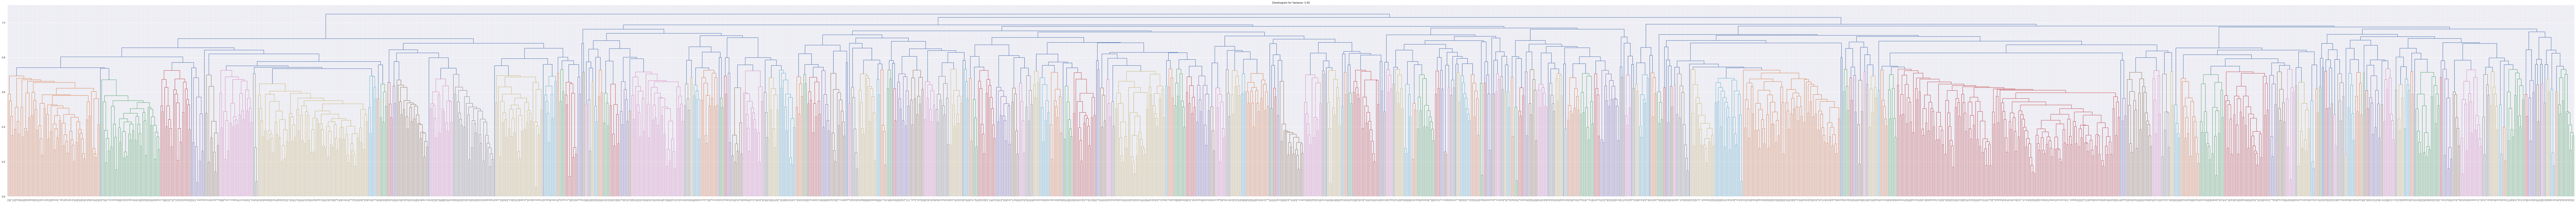

IndexError: list index out of range

In [72]:
timeline_return  = gradio_generate_timeline(index=3)

## Continuation of timeline enhanced 

In [ ]:
# def fetch_timeline():    
#     # Connect to the MongoDB client
#     try:
#         db = mongo_client[config["database"]["name"]]
#         train_documents = db[config["database"]["timelines_collection"]].find()
#         data_list = list(train_documents)

#         # Convert the list of dictionaries to a JSON string
#         json_string = json.dumps(data_list, default=str)  # 'default=str' helps avoid serialization errors

#     except Exception as error: 
#         print(f"Unable to fetch train data from MongoDB. Check your connection the database...\nERROR: {error}\n")
#         sys.exit()   
#     return json_string

# timeline_mongo = json.loads(fetch_timeline())[0]
# timeline = json.loads(timeline_mongo['Timeline'])
# timeline_header = timeline_mongo['Timeline_header']
# print(timeline_header)
# timeline